# Детекция птиц на изображениях

In [5]:
import os

import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [6]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [7]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for i in range(len(boxes)):
        down_left = int(boxes[i][0][0]), int(boxes[i][0][1])
        up_right = int(boxes[i][1][0]), int(boxes[i][1][1])
        cv2.rectangle(img, down_left, up_right, color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, pred_cls[i], down_left, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
        
    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

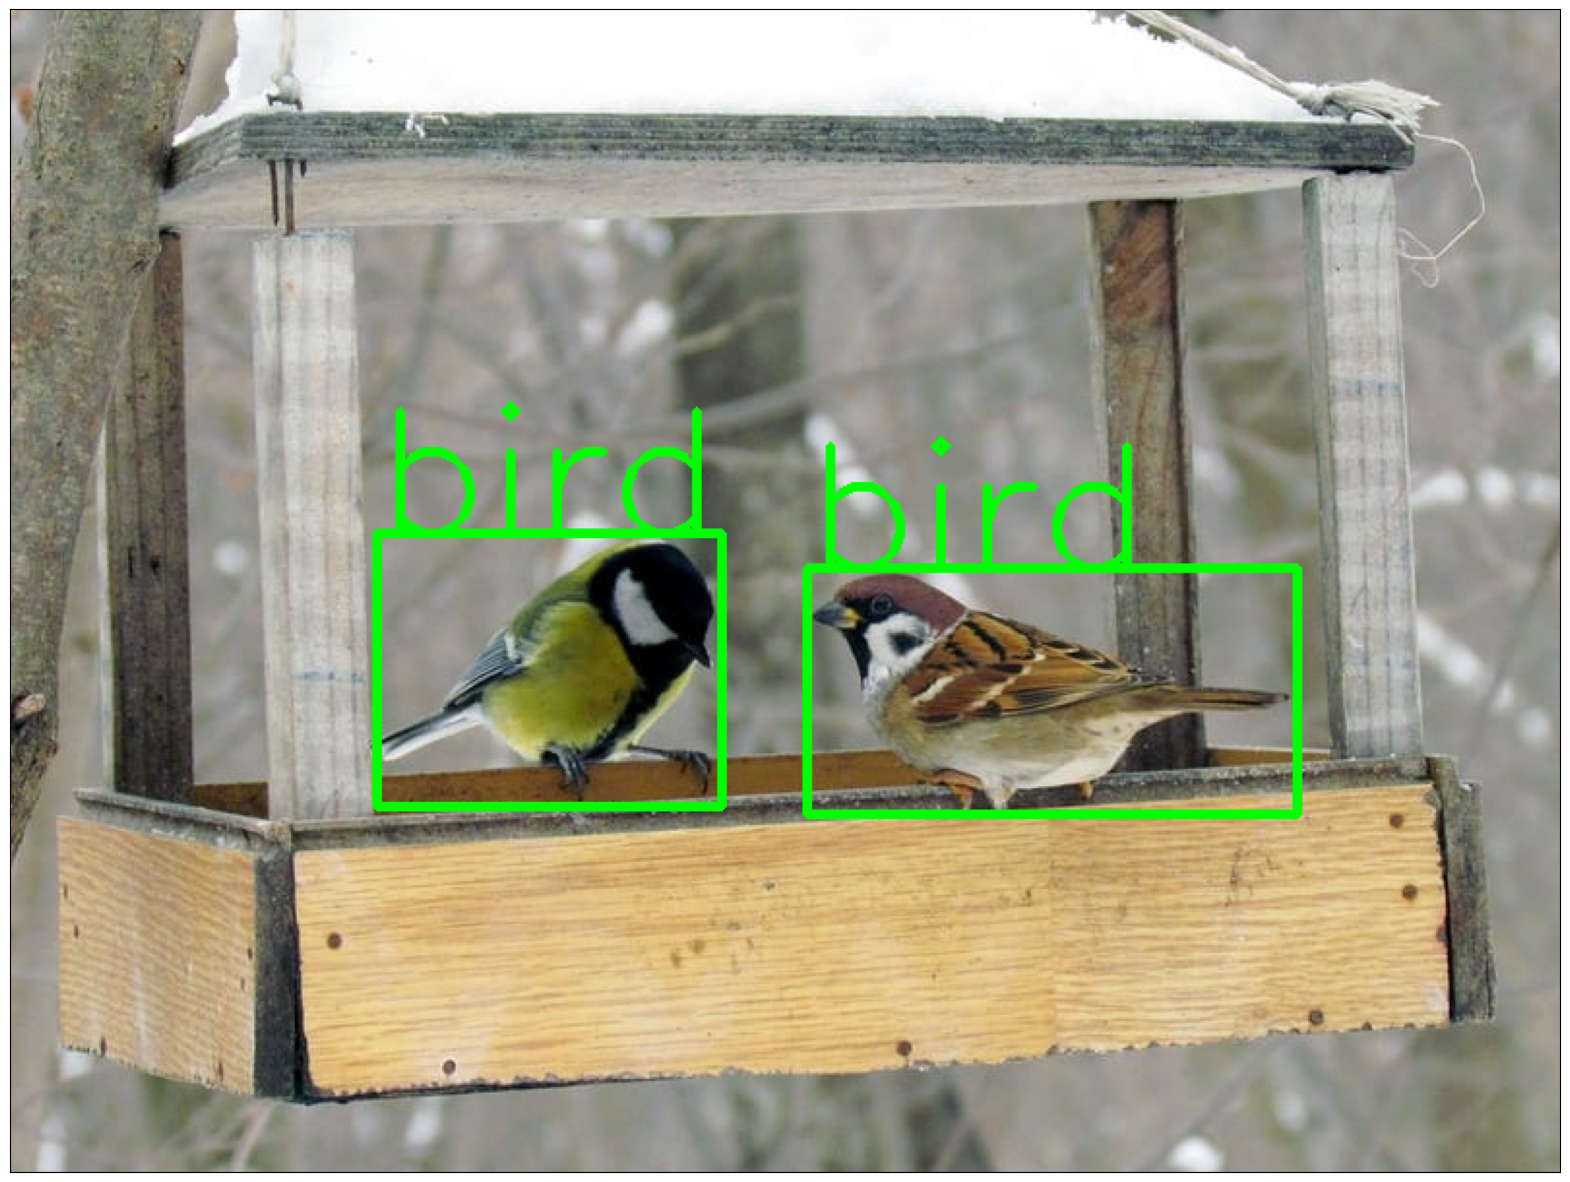

In [8]:
object_detection_api('./test.jpg', threshold=0.8)

In [9]:
models = ["fasterrcnn_resnet50_fpn", "retinanet_resnet50_fpn", "yolov5"]
times_gpu = [0.0, 0.0, 0.0]
times_cpu = [0.0, 0.0, 0.0]
sizes = [0.0, 0.0, 0.0]

In [10]:
import time

def get_prediction_time(img_path, model, device, model_input_type):
    if model_input_type == "img":
        img = Image.open(img_path)
        transform = T.Compose([T.ToTensor()])
        img = transform(img)
        img = img.to(device)
    elif model_input_type == "path":
        img = img_path
    else:
        raise ValueError("model_input_type should be 'img' or 'path'")
    
    model.to(device)
    
    start_time = time.time()
    pred = model([img])
    end_time = time.time()
    
    return end_time - start_time, pred

def get_mean_prediction_time(img_path, model, device, model_input_type = "img", n = 50):
    mean_time = 0
    for i in range(n):
        time, _ = get_prediction_time(img_path, model, device, model_input_type)
        mean_time += time
    mean_time /= n
    return mean_time

def get_size_in_mb(model):
    torch.save(model, "temp.pth")
    file_size = os.path.getsize("temp.pth")
    file_size_mb = file_size / (1024 * 1024)
    os.remove("temp.pth")
    return file_size_mb

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

times_cpu[0] = get_mean_prediction_time('./test.jpg', model, "cpu")
print(f"fasterrcnn_resnet50_fpn on CPU: {times_cpu[0]}")

times_gpu[0] = get_mean_prediction_time('./test.jpg', model, "cuda")
print(f"fasterrcnn_resnet50_fpn on GPU: {times_gpu[0]}")

sizes[0] = get_size_in_mb(model)
print(f"fasterrcnn_resnet50_fpn size: {sizes[0]} MB")

fasterrcnn_resnet50_fpn on CPU: 2.1895550155639647
fasterrcnn_resnet50_fpn on GPU: 0.2105400848388672
fasterrcnn_resnet50_fpn size: 159.8020725250244 MB


In [12]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
model.eval()

times_cpu[1] = get_mean_prediction_time('./test.jpg', model, "cpu")
print(f"retinanet_resnet50_fpn on CPU: {times_cpu[1]}")

times_gpu[1] = get_mean_prediction_time('./test.jpg', model, "cuda")
print(f"retinanet_resnet50_fpn on GPU: {times_gpu[1]}")

sizes[1] = get_size_in_mb(model)
print(f"retinanet_resnet50_fpn size: {sizes[1]} MB")

retinanet_resnet50_fpn on CPU: 2.1039132022857667
retinanet_resnet50_fpn on GPU: 0.22624390125274657
retinanet_resnet50_fpn size: 130.27939987182617 MB


In [13]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

times_cpu[2] = get_mean_prediction_time('./test.jpg', model, "cpu", model_input_type="path")
print(f"yolov5 on CPU: {times_cpu[2]}")

times_gpu[2] = get_mean_prediction_time('./test.jpg', model, "cuda", model_input_type="path")
print(f"yolov5 on GPU: {times_gpu[2]}")

sizes[2] = get_size_in_mb(model)
print(f"yolov5 size: {sizes[2]} MB")

Using cache found in C:\Users\bred7/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-5 Python-3.11.5 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


yolov5 on CPU: 0.15535197257995606
yolov5 on GPU: 0.025937256813049318
yolov5 size: 27.94094467163086 MB


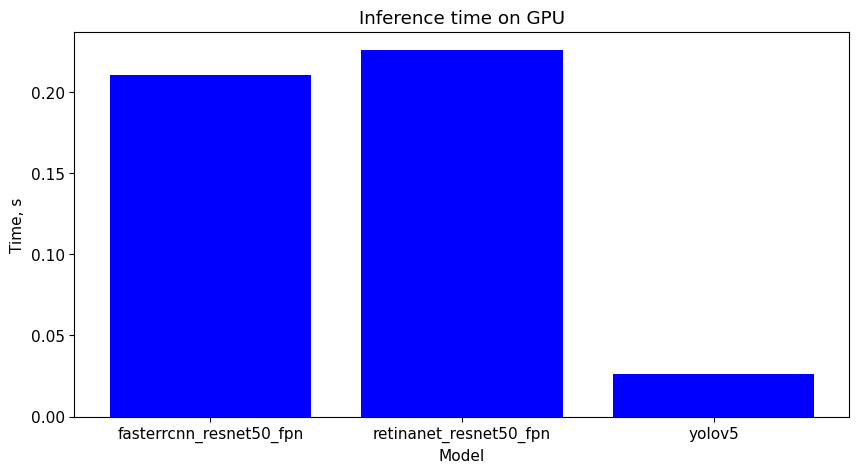

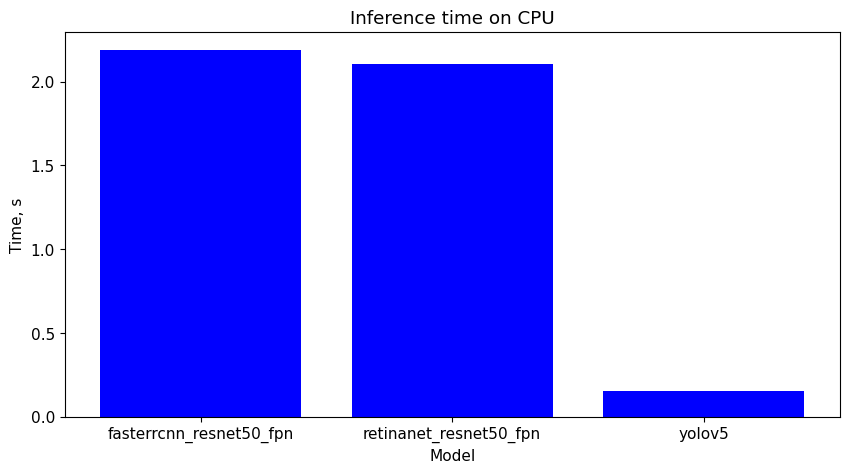

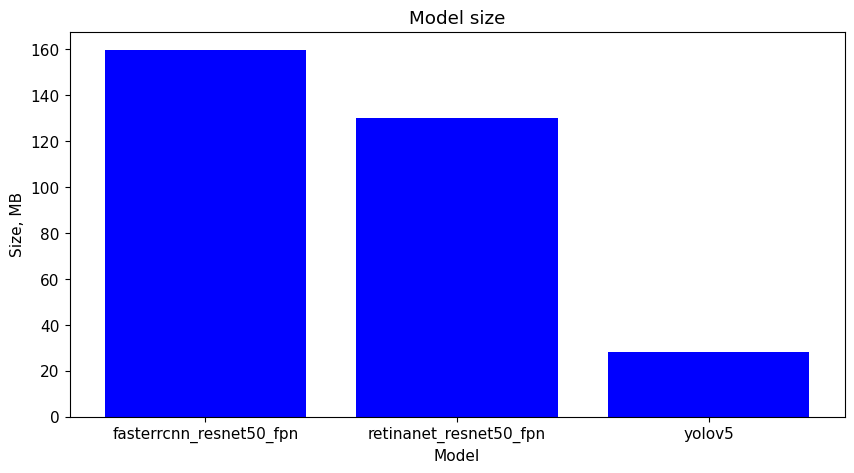

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.bar(models, times_gpu, color='blue')
plt.xlabel("Model")
plt.ylabel("Time, s")
plt.title("Inference time on GPU")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, times_cpu, color='blue')
plt.xlabel("Model")
plt.ylabel("Time, s")
plt.title("Inference time on CPU")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, sizes, color='blue')
plt.xlabel("Model")
plt.ylabel("Size, MB")
plt.title("Model size")
plt.show()

Протестируем данную архитектуру на задаче детекции птиц на фотографиях.
Используем данную модель для трекинга птиц на видео

In [15]:
import torch

images = ["./1.jpg", "./2.jpg", "./3.jpg"]
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

results = model(images)

results.print()
results.save()

Using cache found in C:\Users\bred7/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-5 Python-3.11.5 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/3: 667x1000 1 person, 1 car, 28 birds
image 2/3: 750x1000 11 birds
image 3/3: 3456x5184 5 persons, 11 birds, 1 handbag
Speed: 122.4ms pre-process, 21.6ms inference, 2.3ms NMS per image at shape (3, 3, 480, 640)
Saved 3 images to runs\detect\exp


In [16]:
import cv2

capture = cv2.VideoCapture("video_trimmed.avi")

trackers = []
bboxes = []
init_tracking = False
old_trackers_len = 0

count = 0
while 1:
    count += 1
    ret, frame = capture.read()
    if not ret:
        break
    tracker_box = None
    
    if count % 8 == 0:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # запускаем детектор
        birds = model(frame)
        detections = birds.pred[0]

        # Фильтруем только птиц (класс 16 в COCO)
        birds = detections[detections[:, -1] == 16]
        
        for bird in birds:
            x1, y1, x2, y2 = map(int, bird[:4])
            bbox = (x1, y1, x2 - x1, y2 - y1)
            old_trackers_len = len(trackers)
            trackers.append(cv2.TrackerMIL_create())
            trackers[-1].init(frame, bbox)
            bboxes.append(bbox)
        
        init_tracking = True
    elif count % 10 == 0:
        trackers = trackers[old_trackers_len:]
        bboxes = bboxes[old_trackers_len:]

    if init_tracking:
        # Обновляем трекер и получаем результат трекинга
        for i, tracker in enumerate(trackers):
            success, bbox = tracker.update(frame)
            if success:
                x, y, w, h = [int(v) for v in bbox]
                bboxes[i] = (x, y, w, h)  # Обновляем каждую рамку

        # Рисуем ограничивающие рамки
        for bbox in bboxes:
            x, y, w, h = bbox
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2, 1)  # Рисуем рамки

    cv2.imshow('Birds Tracking:', frame)
    interrupt = cv2.waitKey(10)

    # выход по нажатию на клавишу 'q'
    if  interrupt & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()